<a href="https://colab.research.google.com/github/abmmatthew/dashboards/blob/master/Abraham_ADS_midterm_spring2025.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import os
import urllib
from sklearn.decomposition import PCA
from sklearn.decomposition import KernelPCA
import numpy as np
from scipy.signal import periodogram
import statsmodels.api as sm
import dask.dataframe as dd

from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.arima_model import ARIMA
from matplotlib import pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import PredefinedSplit
import warnings
warnings.filterwarnings('ignore')


Theoretic part

Multiple choice questions: please select all that applies and explain your answer.
Question 1 (Autocorrelation).

The autocorrelation plot of the daily time-series has local peaks at t=7,14,21,28 etc.. How would you interpret that?

A. The time-series reaches its maximum on the days 7,14,21,28...

B. The time-series reaches its minimum on the days 7,14,21,28...

C. The time-series is likely to have a periodic pattern with a period of 7 days

D. The time-series is likely to have 7 periods per day

E. The appropriate AR model for the time-series should have at least 7 terms.

Your answer:
C. The time-series is likely to have a periodic pattern with a period of 7 days
A peak in the autocorrelation function (ACF) at lags of 7, 14, 21, 28 indicates that there is weekly seasonality in the data


Question 2 (Stationarity).

Which of the following time-series models are always stationary:

A. Linear trend

B. MA model

C. White noise

D. Random walk

E. ARMA(1,2) model

F. ARIMA(1,1,1) model

Your answer:
B. MA model (A Moving Average (MA) model is always stationary because it is based on a linear combination of white noise terms, which do not depend on past value)
C. White noise (White noise is stationary and has has a constant mean, constant variance, and no correlation between observations)
E. ARMA(1,2) model (if AR part satisfies stationarity conditions) - ARMA can be stationary if the autoregressive (AR) part satisfies the stationarity condition


Question 3 (PCA).

Which of the following statements regarding the model dimensionality reduction through Principal Component Analysis (PCA) are true:

A. Leading principal components of the features are the most efficient for modeling the output variable.

B. Principal components of the standardized features are uncorrelated and this way less exposed to multicollinearity.

C. The model using principal components of the features can't overfit.

D. Feature selection based on the principal components of the features is often more efficient in preventing overfitting comparered the feature selection over the original features.

E. Principal components are harder to interpret compared to the original features making the PCA regresssion model less interpretable compared to the regression model using original features.

Your answer:
B. Principal components of the standardized features are uncorrelated and this way less exposed to multicollinearity. - PCA transforms the original correlated features into a new set of uncorrelated components
D. Feature selection based on the principal components of the features is often more efficient in preventing overfitting compared to the feature selection over the original features. - PCA removes redundant information and focuses on the most informative directions in the data.
E. Principal components are harder to interpret compared to the original features, making the PCA regression model less interpretable compared to the regression model using original features. - Principal components are linear combinations of the original features and do not have direct making the model harder to interpret.


Question 4 (MapReduce).

What is true about MapReduce:

A. MapReduce is a Python module enabling parallel computing

B. Using MapReduce approach makes the code more suitable for parallel computing.

C. MapReduce code always runs faster compared to the code using more traditional approaches, like loops or list comprehensions.

D. MapReduce code will always efficiently run on multiple cores of your CPU or multiple machines within your cluster if available.

E. Multiprocessing and PySpark efficient alternatives to MapReduce.

Your answer:
B. Using MapReduce approach makes the code more suitable for parallel computing.- Map reduce breaks down tasks into indipendent/reduced steps making it ideal to scale across multiple machines
E. Multiprocessing and PySpark are efficient alternatives to MapReduce.- alternative that optimizes distributed computing without writing explicit MapReduce jobs.


Practice part: Taxi ridership from JFK to other taxi zones prediction.

This project is an example of applying PCA to predict hourly yellow taxi ridership at the taxi zone level. Modeling taxi ridership at a fine spatial and temporal granularity is challenging due to the low signal-to-noise ratio and high dimensionality. In this case, dimension reduction essential in feature engineering. This project has five steps: data downloading, data preprocessing, baseline modeling, feature engineering, and RandomForest modeling.

Let's start with data downloading.



1. Data downloading

Design a function to download yellow taxi data from 2017-01-01 to 2018-12-31 at https://www1.nyc.gov/site/tlc/about/tlc-trip-record-data.page.


In [ ]:
dataDir = 'taxidata'
if os.path.exists(dataDir):
    pass
else:
    os.mkdir(dataDir)
Years = [2017,2018]
Months = range(1,13)
VehicleTypes = ['yellow']

def getUrl(cabtype,year,month):
    baseUrl = 'https://d37ci6vzurychx.cloudfront.net/trip-data/'

    month = str(month).zfill(2)
    fileName = '%s_tripdata_%s-%s.parquet'%(cabtype,year,month)

    return baseUrl + fileName, fileName

In [ ]:
for year in Years:
    for month in Months:
        for cabtype in VehicleTypes:
            url, fileName = getUrl(cabtype,year,month)

            print("Downloading: "+str(fileName))

            if fileName in os.listdir(dataDir):
                print("file exists")
                continue

            filePath = os.path.join(dataDir, fileName)
            try:
                urllib.request.urlretrieve(url, filePath)
            except:
                # if fails remove the incomplete file
                os.remove(filePath)
                try:
                    # start again after a delay of 2 min
                    time.sleep(60*2)
                    urllib.request.urlretrieve(url, filePath)
                except:
                    print("Download this file later!")
                    pass

Downloading: yellow_tripdata_2017-01.parquet
file exists
Downloading: yellow_tripdata_2017-02.parquet
file exists
Downloading: yellow_tripdata_2017-03.parquet
file exists
Downloading: yellow_tripdata_2017-04.parquet
file exists
Downloading: yellow_tripdata_2017-05.parquet
file exists
Downloading: yellow_tripdata_2017-06.parquet
file exists
Downloading: yellow_tripdata_2017-07.parquet
file exists
Downloading: yellow_tripdata_2017-08.parquet
file exists
Downloading: yellow_tripdata_2017-09.parquet
file exists
Downloading: yellow_tripdata_2017-10.parquet
file exists
Downloading: yellow_tripdata_2017-11.parquet
file exists
Downloading: yellow_tripdata_2017-12.parquet
file exists
Downloading: yellow_tripdata_2018-01.parquet
file exists
Downloading: yellow_tripdata_2018-02.parquet
file exists
Downloading: yellow_tripdata_2018-03.parquet
file exists
Downloading: yellow_tripdata_2018-04.parquet
file exists
Downloading: yellow_tripdata_2018-05.parquet
file exists
Downloading: yellow_tripdata_20


2. Data Preprocessing

Use dask to aggregate all months' records into one dataframe, and aggregate dataset by date and hour to get the ridership from JFK to each taxi zone each hour. The expected output has columns: date, hour, drop-off location 1, drop-off location 2, etc.

Hint:

    JFK taxi zone id is 132.
    time column should be the pickup time, and ridership is passenger count.
    Try read_parquet("*.parquet") to read all parquet file in a folder
    files in 2017 and 2018 have different columns; apply argument usecols to select desired columns.
    using .compute() function to convert processed dask dataframe to pandas dataframe for further modeling.



In [ ]:
import os
import urllib.request
import time
import dask.dataframe as dd
import pandas as pd
import numpy as np

dataDir = 'taxidata'
outputFile = 'aggregated_ridership.csv'

# Ensure data directory exists
if not os.path.exists(dataDir):
    os.mkdir(dataDir)

Years = [2017, 2018]
Months = range(1, 13)
VehicleTypes = ['yellow']

def getUrl(cabtype, year, month):
    baseUrl = 'https://d37ci6vzurychx.cloudfront.net/trip-data/'
    month = str(month).zfill(2)
    fileName = f'{cabtype}_tripdata_{year}-{month}.parquet'
    return baseUrl + fileName, fileName

def download_data():
    for year in Years:
        for month in Months:
            for cabtype in VehicleTypes:
                url, fileName = getUrl(cabtype, year, month)
                filePath = os.path.join(dataDir, fileName)

                print(f"Downloading: {fileName}")

                if fileName in os.listdir(dataDir):
                    print("File exists, skipping...")
                    continue

                try:
                    urllib.request.urlretrieve(url, filePath)
                except Exception as e:
                    print(f"Error downloading {fileName}: {e}")
                    if os.path.exists(filePath):
                        os.remove(filePath)

                    # Retry after delay
                    print("Retrying in 2 minutes...")
                    time.sleep(120)
                    try:
                        urllib.request.urlretrieve(url, filePath)
                    except Exception as e:
                        print(f"Failed to download {fileName} again: {e}. Download manually if needed.")
                        pass

def preprocess_data():
    desired_columns = ['tpep_pickup_datetime', 'PULocationID', 'DOLocationID', 'passenger_count']
    df = dd.read_parquet(os.path.join(dataDir, "*.parquet"), engine='pyarrow', columns=desired_columns)
    df['tpep_pickup_datetime'] = dd.to_datetime(df['tpep_pickup_datetime'], errors='coerce')
    df = df[df['PULocationID'] == 132]
    df['date'] = df['tpep_pickup_datetime'].dt.date
    df['hour'] = df['tpep_pickup_datetime'].dt.hour

    # Filter out incorrect dates outside 2017-2018
    df = df[(df['date'] >= pd.to_datetime('2017-01-01').date()) & (df['date'] <= pd.to_datetime('2018-12-31').date())]

    print("Min Date:", df['date'].min().compute())
    print("Max Date:", df['date'].max().compute())

    df_grouped = df.groupby(['date', 'hour', 'DOLocationID'])['passenger_count'].sum().reset_index()
    final_df = df_grouped.compute().pivot(index=['date', 'hour'], columns='DOLocationID', values='passenger_count').fillna(0)
    final_df = final_df.reset_index()

    all_dates = pd.date_range(start='2017-01-01', end='2018-12-31', freq='D')
    hours = np.arange(24)
    all_combinations = pd.MultiIndex.from_product([all_dates, hours], names=['date', 'hour'])
    final_df.set_index(['date', 'hour'], inplace=True)
    final_df = final_df.reindex(all_combinations, fill_value=0).reset_index()
    final_df.to_csv(outputFile, index=False)

    print(f"Final processed data saved to {outputFile} with {len(final_df)} rows")
    print(final_df.head(10))

def load_data(file_path=outputFile):
    if os.path.exists(file_path):
        df_loaded = pd.read_csv(file_path)
        print("Data loaded successfully:")
        print(df_loaded.head(10))
        return df_loaded
    else:
        print("Error: File not found.")
        return None

if __name__ == "__main__":
    download_data()
    preprocess_data()
    loaded_df = load_data()

Downloading: yellow_tripdata_2017-01.parquet
File exists, skipping...
Downloading: yellow_tripdata_2017-02.parquet
File exists, skipping...
Downloading: yellow_tripdata_2017-03.parquet
File exists, skipping...
Downloading: yellow_tripdata_2017-04.parquet
File exists, skipping...
Downloading: yellow_tripdata_2017-05.parquet
File exists, skipping...
Downloading: yellow_tripdata_2017-06.parquet
File exists, skipping...
Downloading: yellow_tripdata_2017-07.parquet
File exists, skipping...
Downloading: yellow_tripdata_2017-08.parquet
File exists, skipping...
Downloading: yellow_tripdata_2017-09.parquet
File exists, skipping...
Downloading: yellow_tripdata_2017-10.parquet
File exists, skipping...
Downloading: yellow_tripdata_2017-11.parquet
File exists, skipping...
Downloading: yellow_tripdata_2017-12.parquet
File exists, skipping...
Downloading: yellow_tripdata_2018-01.parquet
File exists, skipping...
Downloading: yellow_tripdata_2018-02.parquet
File exists, skipping...
Downloading: yellow_

2.2 Sanity check

Then, we need to do some basic sanity checks. It is possible that in a particular hour, completely dispatched no yellow taxis from JFK. Check does each day has 24-hour records and add missing records back to the dataframe. The final output should have 17520 rows (365 X2 X 24)

In [ ]:
def sanity_check(file_path=outputFile):
    if not os.path.exists(file_path):
        print("Error: Processed file not found!")
        return

    df = pd.read_csv(file_path)
    expected_rows = 365 * 2 * 24  # 17520 rows expected
    actual_rows = len(df)

    print(f"Sanity Check: Expected Rows = {expected_rows}, Actual Rows = {actual_rows}")

    if actual_rows == expected_rows:
        print("✅ Sanity Check Passed: Dataset has the correct number of records.")
    else:
        print("❌ Sanity Check Failed: Dataset has incorrect number of records.")
        missing_records = expected_rows - actual_rows
        print(f"Missing Records: {missing_records}")

def load_data(file_path=outputFile):
    if os.path.exists(file_path):
        df_loaded = pd.read_csv(file_path)
        print("Data loaded successfully:")
        print(df_loaded.head(10))
        return df_loaded
    else:
        print("Error: File not found.")
        return None

if __name__ == "__main__":
    download_data()
    preprocess_data()
    sanity_check()
    loaded_df = load_data()

Downloading: yellow_tripdata_2017-01.parquet
File exists, skipping...
Downloading: yellow_tripdata_2017-02.parquet
File exists, skipping...
Downloading: yellow_tripdata_2017-03.parquet
File exists, skipping...
Downloading: yellow_tripdata_2017-04.parquet
File exists, skipping...
Downloading: yellow_tripdata_2017-05.parquet
File exists, skipping...
Downloading: yellow_tripdata_2017-06.parquet
File exists, skipping...
Downloading: yellow_tripdata_2017-07.parquet
File exists, skipping...
Downloading: yellow_tripdata_2017-08.parquet
File exists, skipping...
Downloading: yellow_tripdata_2017-09.parquet
File exists, skipping...
Downloading: yellow_tripdata_2017-10.parquet
File exists, skipping...
Downloading: yellow_tripdata_2017-11.parquet
File exists, skipping...
Downloading: yellow_tripdata_2017-12.parquet
File exists, skipping...
Downloading: yellow_tripdata_2018-01.parquet
File exists, skipping...
Downloading: yellow_tripdata_2018-02.parquet
File exists, skipping...
Downloading: yellow_


3. Time-series exploratory analysis

Apply exploratory analysis over the daily aggregated dataset at first.
3.1 aggregate the ridership from each dropoff location and sum it to get daily records.

In [ ]:
import os
import urllib.request
import time
import dask.dataframe as dd
import pandas as pd
import numpy as np

dataDir = 'taxidata'
outputFile = 'aggregated_ridership.csv'

def getUrl(cabtype, year, month):
    baseUrl = 'https://d37ci6vzurychx.cloudfront.net/trip-data/'
    month = str(month).zfill(2)
    fileName = f'{cabtype}_tripdata_{year}-{month}.parquet'
    return baseUrl + fileName, fileName

def preprocess_data():
    desired_columns = ['tpep_pickup_datetime', 'PULocationID', 'DOLocationID', 'passenger_count']
    df = dd.read_parquet(os.path.join(dataDir, "*.parquet"), engine='pyarrow', columns=desired_columns)
    df['tpep_pickup_datetime'] = dd.to_datetime(df['tpep_pickup_datetime'], errors='coerce')
    df = df[df['PULocationID'] == 132]
    df['date'] = df['tpep_pickup_datetime'].dt.date

    # Filter out incorrect dates outside 2017-2018
    df = df[(df['date'] >= pd.to_datetime('2017-01-01').date()) & (df['date'] <= pd.to_datetime('2018-12-31').date())]

    df_grouped = df.groupby(['date', 'DOLocationID'])['passenger_count'].sum().reset_index()
    final_df = df_grouped.compute().pivot(index='date', columns='DOLocationID', values='passenger_count').fillna(0)
    final_df = final_df.reset_index()

    final_df.to_csv(outputFile, index=False)

    print(f"Final processed data saved to {outputFile} with {len(final_df)} rows")
    print(final_df.head(10))

if __name__ == "__main__":
    preprocess_data()

Final processed data saved to aggregated_ridership.csv with 730 rows
DOLocationID        date     1    2     3     4    5    6      7    8     9  \
0             2017-01-01  15.0  1.0   0.0  72.0  0.0  4.0  136.0  0.0  27.0   
1             2017-01-02  13.0  0.0   4.0  74.0  0.0  0.0  192.0  0.0  11.0   
2             2017-01-03  26.0  0.0   9.0  47.0  0.0  0.0  171.0  2.0  17.0   
3             2017-01-04  21.0  0.0   3.0  43.0  0.0  5.0  142.0  0.0   3.0   
4             2017-01-05   8.0  1.0   3.0  58.0  0.0  0.0   83.0  0.0   8.0   
5             2017-01-06  36.0  0.0   8.0  41.0  0.0  1.0  112.0  0.0   5.0   
6             2017-01-07  34.0  0.0  14.0  33.0  0.0  1.0   92.0  0.0   7.0   
7             2017-01-08  67.0  0.0   4.0  58.0  0.0  2.0  216.0  0.0   8.0   
8             2017-01-09  20.0  0.0   3.0  84.0  0.0  5.0  137.0  0.0   5.0   
9             2017-01-10  30.0  0.0  10.0  30.0  1.0  1.0  113.0  0.0  18.0   

DOLocationID  ...    256   257   258   259   260    261    26


3.2 Period detection and report the strongest period length on the 2017 data.

Hint: using periodogram or acf plot.


Final processed data saved to aggregated_ridership.csv with 730 rows
DOLocationID        date     1    2     3     4    5    6      7    8     9  \
0             2017-01-01  15.0  1.0   0.0  72.0  0.0  4.0  136.0  0.0  27.0   
1             2017-01-02  13.0  0.0   4.0  74.0  0.0  0.0  192.0  0.0  11.0   
2             2017-01-03  26.0  0.0   9.0  47.0  0.0  0.0  171.0  2.0  17.0   
3             2017-01-04  21.0  0.0   3.0  43.0  0.0  5.0  142.0  0.0   3.0   
4             2017-01-05   8.0  1.0   3.0  58.0  0.0  0.0   83.0  0.0   8.0   
5             2017-01-06  36.0  0.0   8.0  41.0  0.0  1.0  112.0  0.0   5.0   
6             2017-01-07  34.0  0.0  14.0  33.0  0.0  1.0   92.0  0.0   7.0   
7             2017-01-08  67.0  0.0   4.0  58.0  0.0  2.0  216.0  0.0   8.0   
8             2017-01-09  20.0  0.0   3.0  84.0  0.0  5.0  137.0  0.0   5.0   
9             2017-01-10  30.0  0.0  10.0  30.0  1.0  1.0  113.0  0.0  18.0   

DOLocationID  ...    256   257   258   259   260    261    26

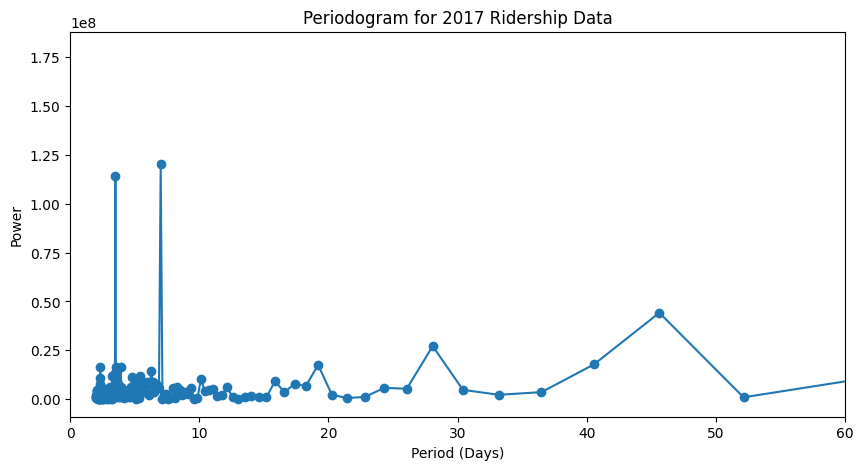

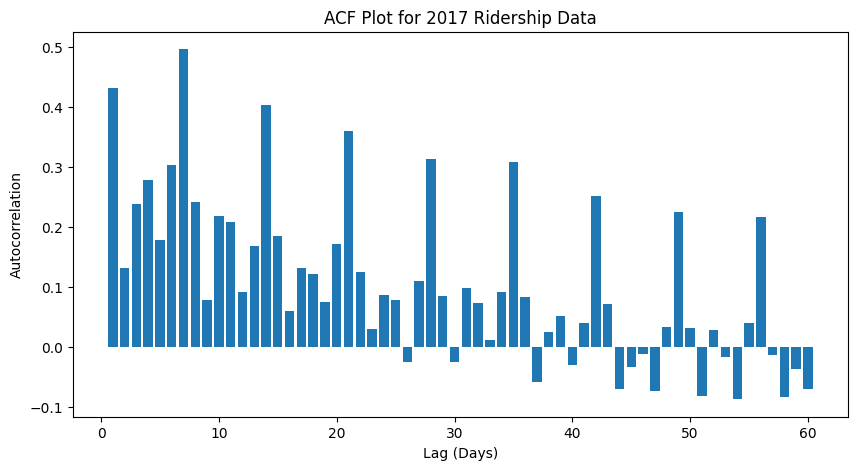

Strongest period detected: 7 days


In [ ]:
from statsmodels.tsa.stattools import acf
def detect_periodicity(file_path=outputFile):
    if not os.path.exists(file_path):
        print("Error: Processed file not found!")
        return

    df = pd.read_csv(file_path)
    df['date'] = pd.to_datetime(df['date'])
    df_2017 = df[df['date'].dt.year == 2017]
    df_2017['total_ridership'] = df_2017.iloc[:, 1:].sum(axis=1)  # Summing across all drop-off locations

    #### Compute and plot Periodogram
    freqs, power = periodogram(df_2017['total_ridership'], detrend='linear')
    plt.figure(figsize=(10, 5))
    plt.plot(1 / freqs, power, marker='o', linestyle='-')
    plt.xlabel('Period (Days)')
    plt.ylabel('Power')
    plt.title('Periodogram for 2017 Ridership Data')
    plt.xlim([0, 60])  # Focus on periods up to 60 days
    plt.show()

    ### Compute ACF
    acf_values = acf(df_2017['total_ridership'], nlags=60)
    plt.figure(figsize=(10, 5))
    plt.bar(range(1, 61), acf_values[1:])
    plt.xlabel('Lag (Days)')
    plt.ylabel('Autocorrelation')
    plt.title('ACF Plot for 2017 Ridership Data')
    plt.show()

    ### Determine the strongest period
    strongest_period = np.argmax(acf_values[1:]) + 1  ### Adding 1 to shift to correct lag value
    print(f"Strongest period detected: {strongest_period} days")

if __name__ == "__main__":
    preprocess_data()
    detect_periodicity()

3.3 Trend, seasonality, noise decomposition (using additive model) on 2017 data, .

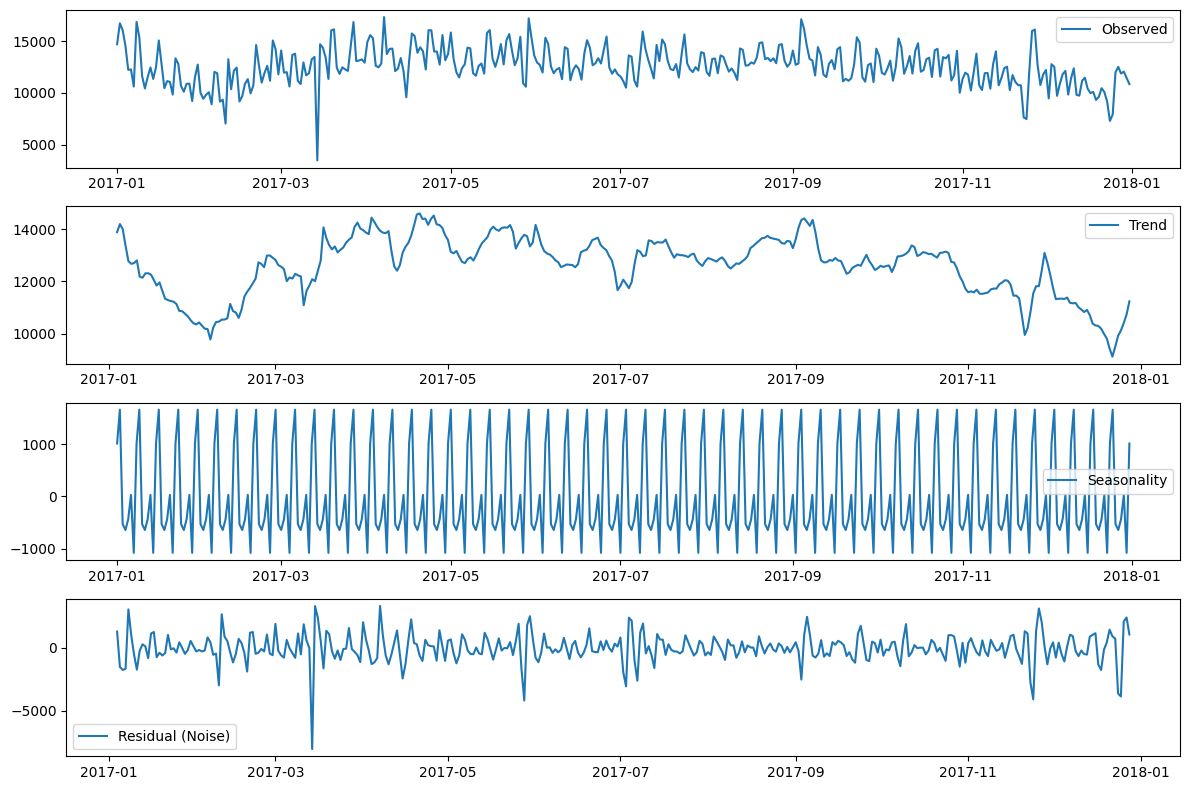

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose

# Load the processed dataset
file_path = 'aggregated_ridership.csv'
if not os.path.exists(file_path):
    print("Error: Processed file not found!")
else:
    df = pd.read_csv(file_path)
    df['date'] = pd.to_datetime(df['date'])

    # Filter for 2017 data
    df_2017 = df[df['date'].dt.year == 2017]
    df_2017['total_ridership'] = df_2017.iloc[:, 1:].sum(axis=1)
    df_2017.set_index('date', inplace=True)

    # Apply seasonal decomposition (additive model)
    decomposition = seasonal_decompose(df_2017['total_ridership'], model='additive', period=7)

    # Plot decomposition
    plt.figure(figsize=(12, 8))
    plt.subplot(411)
    plt.plot(decomposition.observed, label='Observed')
    plt.legend()
    plt.subplot(412)
    plt.plot(decomposition.trend, label='Trend')
    plt.legend()
    plt.subplot(413)
    plt.plot(decomposition.seasonal, label='Seasonality')
    plt.legend()
    plt.subplot(414)
    plt.plot(decomposition.resid, label='Residual (Noise)')
    plt.legend()
    plt.tight_layout()
    plt.show()


4. Predict the total daily ridership from JFK using ARIMA.

ARIMA is a common method to predict taxi ridership. Before we predict taxi zone level hourly ridership, let's try to predict the aggregated daily ridership using ARIMA.
4.1 Using adfuller test to test the stability of the aggregated dataset. If not stable, apply differencing method until the p-value from adfuller test is smaller than 0.05.

In [ ]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA

# Load the processed dataset
file_path = 'aggregated_ridership.csv'
if not os.path.exists(file_path):
    print("Error: Processed file not found!")
else:
    df = pd.read_csv(file_path)
    df['date'] = pd.to_datetime(df['date'])

    # Aggregate total ridership per day
    df_2017 = df[df['date'].dt.year == 2017]
    df_2017['total_ridership'] = df_2017.iloc[:, 1:].sum(axis=1)
    df_2017.set_index('date', inplace=True)

    # Perform ADF test to check stationarity
    def check_stationarity(timeseries):
        result = adfuller(timeseries)
        print(f"ADF Statistic: {result[0]}")
        print(f"p-value: {result[1]}")
        print("Critical Values:")
        for key, value in result[4].items():
            print(f"   {key}: {value}")
        return result[1]  # Return p-value

    # Check initial stationarity
    p_value = check_stationarity(df_2017['total_ridership'])
    d = 0

    # Apply differencing until stationary (p-value < 0.05)
    while p_value >= 0.05:
        d += 1
        df_2017[f'diff_{d}'] = df_2017['total_ridership'].diff(d).dropna()
        p_value = check_stationarity(df_2017[f'diff_{d}'].dropna())

    print(f"Final differencing order (d): {d}")

ADF Statistic: -2.1384593949619797
p-value: 0.22933361924981144
Critical Values:
   1%: -3.4491725955218655
   5%: -2.8698334971428574
   10%: -2.5711883591836733
ADF Statistic: -7.244186084598137
p-value: 1.8506387429075596e-10
Critical Values:
   1%: -3.4491725955218655
   5%: -2.8698334971428574
   10%: -2.5711883591836733
Final differencing order (d): 1



4.2 build an ARIMA model using terms [P=0, D=1, Q=1], training on the first 700 days, forecast on the last 31 days. Print ARIMA model results and plot in-sample and out-of-sample prediction in different colors.

P=0
D=1
Q=1

# fit model
N = 700


                               SARIMAX Results                                
Dep. Variable:        total_ridership   No. Observations:                  334
Model:                 ARIMA(0, 1, 1)   Log Likelihood               -2950.528
Date:                Thu, 20 Mar 2025   AIC                           5905.057
Time:                        10:14:40   BIC                           5912.673
Sample:                    01-01-2017   HQIC                          5908.094
                         - 11-30-2017                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.8939      0.025    -35.993      0.000      -0.943      -0.845
sigma2      2.843e+06   1.58e+05     17.974      0.000    2.53e+06    3.15e+06
Ljung-Box (L1) (Q):                  13.99   Jarque-

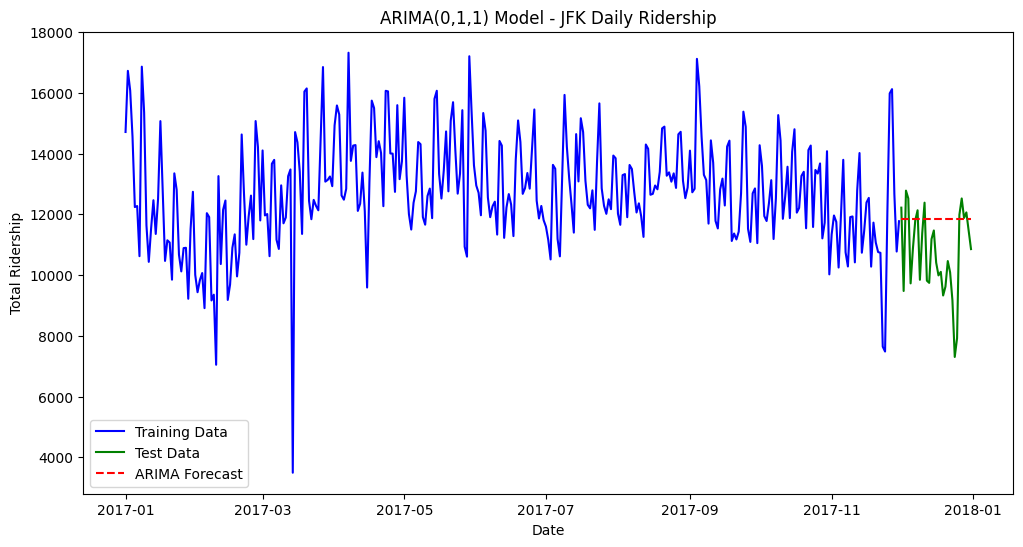

In [ ]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA

# Load the processed dataset
file_path = 'aggregated_ridership.csv'
if not os.path.exists(file_path):
    print("Error: Processed file not found!")
else:
    df = pd.read_csv(file_path)
    df['date'] = pd.to_datetime(df['date'])

    # Aggregate total ridership per day
    df_2017 = df[df['date'].dt.year == 2017]
    df_2017['total_ridership'] = df_2017.iloc[:, 1:].sum(axis=1)
    df_2017.set_index('date', inplace=True)

    # Adjust training size dynamically to ensure at least 31 days for testing
    N = min(700, len(df_2017) - 31)
    train, test = df_2017.iloc[:N], df_2017.iloc[N:]

    if len(test) == 0:
        print("Warning: Not enough data for a test set. Reducing training size.")
        N = max(1, len(df_2017) - 31)
        train, test = df_2017.iloc[:N], df_2017.iloc[N:]

    # Fit ARIMA model with (0,1,1) parameters
    model = ARIMA(train['total_ridership'], order=(0, 1, 1))
    model_fit = model.fit()

    # Print ARIMA model summary
    print(model_fit.summary())

    # Forecast the next 31 days
    forecast = model_fit.forecast(steps=31)

    # Ensure test_dates has valid dates
    if len(test) > 0:
        test_start_date = test.index.min()
        test_dates = pd.date_range(start=test_start_date, periods=31, freq='D')
    else:
        print("Warning: Test dataset is empty or has no valid index values.")
        test_dates = pd.date_range(start=train.index.max(), periods=31, freq='D')

    # Plot results
    plt.figure(figsize=(12, 6))
    plt.plot(train.index, train['total_ridership'], label='Training Data', color='blue')
    plt.plot(test.index, test['total_ridership'], label='Test Data', color='green')
    plt.plot(test_dates, forecast, label='ARIMA Forecast', color='red', linestyle='dashed')

    plt.xlabel('Date')
    plt.ylabel('Total Ridership')
    plt.title('ARIMA(0,1,1) Model - JFK Daily Ridership')
    plt.legend()
    plt.show()

Taxi zone level prediction

This project aims to predict hourly yellow taxi ridership volume from JFK to each taxi zone. The ARIMA experiment in section 3 forecasts the total ridership amount from JFK. However, based on the reported
, this model is not a good fit. ARIMA model has four main shortcomings: 1) they rely heavily on stationarity assumption which does not hold in real-world traffic systems 2) they do not consider spatial and structural dependencies that traffic networks exhibit and forecast each sensor as an individual time series 3) they are unable to model non-linear temporal dynamics 4) they suffer from the curse of dimensionality. Due to the limitation of ARIMA, we need to apply another method to predict taxi zone level ridership.


5. Feature engineering

Our workflow is first standardizing the dataset, then using PCA to compress the dataset. As we predict future ridership, PCA should be learned from historical data (2017) then apply to the following year (2018). Next, add lag features (PCA components) from the past 12 hours and apply a Random Forest regressor to predict each PCA component's values in the next hour. After we had the PCA component prediction, inverse PCA, and inverse standardization to retrieve taxi ridership prediction in its original scale and dimension, in other words, we are predicting the PCA components instead of taxi zone level ridership and then using the inverse PCA method to reconstruct

Mean Squared Error: 289.28196838904324


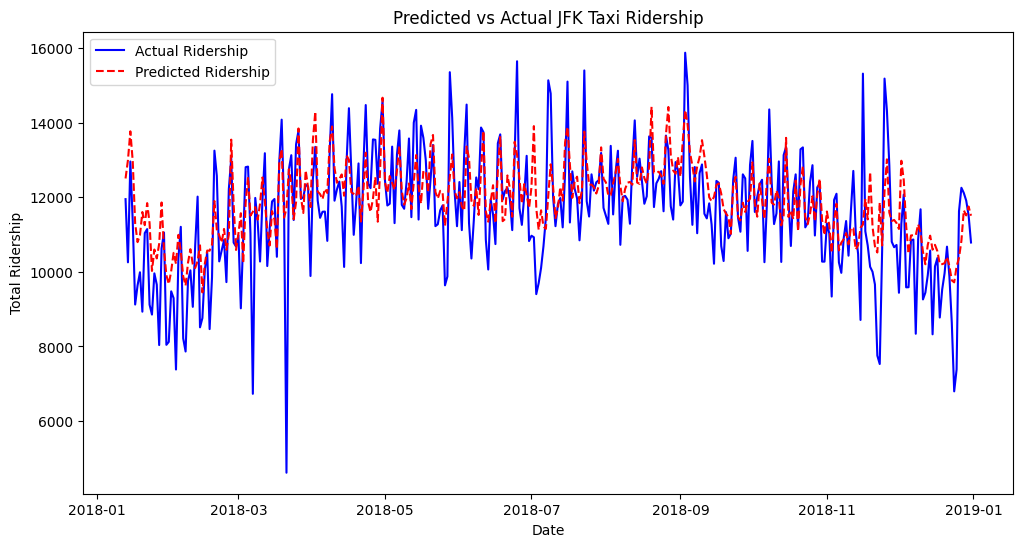

In [ ]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

# Load the processed dataset
file_path = 'aggregated_ridership.csv'
if not os.path.exists(file_path):
    print("Error: Processed file not found!")
else:
    df = pd.read_csv(file_path)
    df['date'] = pd.to_datetime(df['date'])
    df.set_index('date', inplace=True)

    # Split data into 2017 (train) and 2018 (test)
    df_2017 = df[df.index.year == 2017]
    df_2018 = df[df.index.year == 2018]

    # Standardize the dataset
    scaler = StandardScaler()
    df_2017_scaled = scaler.fit_transform(df_2017)
    df_2018_scaled = scaler.transform(df_2018)

    # Apply PCA
    pca = PCA(n_components=10)  # Keeping top 10 components
    pca_2017 = pca.fit_transform(df_2017_scaled)
    pca_2018 = pca.transform(df_2018_scaled)

    # Convert PCA output to DataFrame
    pca_columns = [f'PC{i+1}' for i in range(10)]
    df_pca_2017 = pd.DataFrame(pca_2017, index=df_2017.index, columns=pca_columns)
    df_pca_2018 = pd.DataFrame(pca_2018, index=df_2018.index, columns=pca_columns)

    # Add lag features (last 12 hours)
    for lag in range(1, 13):
        for col in pca_columns:
            df_pca_2017[f'{col}_lag{lag}'] = df_pca_2017[col].shift(lag)
            df_pca_2018[f'{col}_lag{lag}'] = df_pca_2018[col].shift(lag)

    df_pca_2017.dropna(inplace=True)
    df_pca_2018.dropna(inplace=True)

    # Train Random Forest Regressor
    X_train, y_train = df_pca_2017.drop(columns=pca_columns), df_pca_2017[pca_columns]
    X_test, y_test = df_pca_2018.drop(columns=pca_columns), df_pca_2018[pca_columns]

    rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
    rf_model.fit(X_train, y_train)

    # Predict PCA components
    pca_predictions = rf_model.predict(X_test)

    # Inverse PCA transformation
    ridership_predictions_scaled = pca.inverse_transform(pca_predictions)
    ridership_predictions = scaler.inverse_transform(ridership_predictions_scaled)

    # Convert predictions to DataFrame
    df_predictions = pd.DataFrame(ridership_predictions, index=df_pca_2018.index, columns=df_2018.columns)

    # Align test set with predictions
    df_2018_trimmed = df_2018.iloc[-len(df_predictions):]  # Keep only last matching rows

    # Evaluate performance
    mse = mean_squared_error(df_2018_trimmed, df_predictions)
    print(f"Mean Squared Error: {mse}")

    # Plot actual vs predicted
    plt.figure(figsize=(12, 6))
    plt.plot(df_2018_trimmed.index, df_2018_trimmed.sum(axis=1), label='Actual Ridership', color='blue')
    plt.plot(df_predictions.index, df_predictions.sum(axis=1), label='Predicted Ridership', color='red', linestyle='dashed')

    plt.xlabel('Date')
    plt.ylabel('Total Ridership')
    plt.title('Predicted vs Actual JFK Taxi Ridership')
    plt.legend()
    plt.show()


5.1. standardization.

The standardscaler stores information of this standardization process, including the mean and standard deviation values required when converting the prediction back to the raw scale. Split the whole dataset into two parts: 2017 and 2018, standardize each separately.


In [ ]:
import os
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler

# Load the processed dataset
file_path = 'aggregated_ridership.csv'
if not os.path.exists(file_path):
    print("Error: Processed file not found!")
else:
    df = pd.read_csv(file_path)
    df['date'] = pd.to_datetime(df['date'])
    df.set_index('date', inplace=True)

    # Split data into 2017 (train) and 2018 (test)
    df_2017 = df[df.index.year == 2017]
    df_2018 = df[df.index.year == 2018]

    # Standardize each dataset separately
    scaler_2017 = StandardScaler()
    df_2017_scaled = scaler_2017.fit_transform(df_2017)

    scaler_2018 = StandardScaler()
    df_2018_scaled = scaler_2018.fit_transform(df_2018)

    # Convert back to DataFrame
    df_2017_scaled = pd.DataFrame(df_2017_scaled, index=df_2017.index, columns=df_2017.columns)
    df_2018_scaled = pd.DataFrame(df_2018_scaled, index=df_2018.index, columns=df_2018.columns)

    # Save scalers for inverse transformation
    import joblib
    joblib.dump(scaler_2017, 'scaler_2017.pkl')
    joblib.dump(scaler_2018, 'scaler_2018.pkl')

    print("Standardization complete. Scalers saved for later inverse transformation.")


Standardization complete. Scalers saved for later inverse transformation.


5.2. PCA

Train PCA on the standardized 2018 dataset. Set PCA components as 5, and gamma is None, use kernel ‘linear’. Report the mean squared error between the standardized data and reconstructed data. Hint: fit the PCA on 2017 data and apply it to transform 2018 data.

In [ ]:
import os
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
from sklearn.metrics import mean_squared_error
import joblib

# Load the processed dataset
file_path = 'aggregated_ridership.csv'
if not os.path.exists(file_path):
    print("Error: Processed file not found!")
else:
    df = pd.read_csv(file_path)
    df['date'] = pd.to_datetime(df['date'])
    df.set_index('date', inplace=True)

    # Load standardization scalers
    scaler_2017 = joblib.load('scaler_2017.pkl')
    scaler_2018 = joblib.load('scaler_2018.pkl')

    # Standardize data
    df_2017_scaled = scaler_2017.transform(df[df.index.year == 2017])
    df_2018_scaled = scaler_2018.transform(df[df.index.year == 2018])

    # Train PCA on 2017 standardized data
    pca = PCA(n_components=5)
    pca.fit(df_2017_scaled)

    # Apply PCA transformation on 2018 data
    pca_2018 = pca.transform(df_2018_scaled)

    # Reconstruct data using inverse PCA
    reconstructed_2018 = pca.inverse_transform(pca_2018)

    # Compute Mean Squared Error (MSE) between original and reconstructed data
    mse = mean_squared_error(df_2018_scaled, reconstructed_2018)
    print(f"Mean Squared Error between standardized and reconstructed data: {mse}")

    # Save PCA model
    joblib.dump(pca, 'pca_model.pkl')
    print("PCA model saved for later use.")


Mean Squared Error between standardized and reconstructed data: 0.7466653176662953
PCA model saved for later use.



5.3 Add lag

add 12 lags of each component (pca_comps=5) (compressed 2018 data only). The expected output should have 65 dimensions. In the further modeling step, we will apply the 60 lag variables to predict the 5 components.


In [ ]:
import os
import pandas as pd
import numpy as np
import joblib

# Load the processed dataset
file_path = 'aggregated_ridership.csv'
if not os.path.exists(file_path):
    print("Error: Processed file not found!")
else:
    df = pd.read_csv(file_path)
    df['date'] = pd.to_datetime(df['date'])
    df.set_index('date', inplace=True)

    # Load PCA model
    pca = joblib.load('pca_model.pkl')

    # Load and standardize 2018 data
    scaler_2018 = joblib.load('scaler_2018.pkl')
    df_2018_scaled = scaler_2018.transform(df[df.index.year == 2018])

    # Apply PCA transformation on 2018 data
    pca_2018 = pca.transform(df_2018_scaled)

    # Convert PCA output to DataFrame
    pca_columns = [f'PC{i+1}' for i in range(5)]
    df_pca_2018 = pd.DataFrame(pca_2018, index=df[df.index.year == 2018].index, columns=pca_columns)

    # Add 12 lag features for each PCA component
    for lag in range(1, 13):
        for col in pca_columns:
            df_pca_2018[f'{col}_lag{lag}'] = df_pca_2018[col].shift(lag)

    df_pca_2018.dropna(inplace=True)  # Remove rows with NaN due to lagging

    # Expected output should have 65 dimensions (5 PCA components + 60 lag variables)
    print(f"Final dataset shape after adding lag features: {df_pca_2018.shape}")

    # Save the dataset with lag features
    df_pca_2018.to_csv('pca_lagged_2018.csv')
    print("PCA lagged dataset saved.")

Final dataset shape after adding lag features: (353, 65)
PCA lagged dataset saved.



6. RandomForest modeling

We aim at predicting compressed daily ridership (5 PCA components values) from 12-hour lag variables. Parameter tuning is required in this section, including min_samples_split, min_samples_leaf, and n_estimators. First 80% days for training, test on the rest 20%. And in the training dataset, validate the model on the bottom 20%.


In [ ]:
import os
import pandas as pd
import numpy as np
import joblib
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error

# Load the dataset with lag features
file_path = 'pca_lagged_2018.csv'
if not os.path.exists(file_path):
    print("Error: Processed file not found!")
else:
    df_pca_lagged = pd.read_csv(file_path, index_col='date', parse_dates=True)

    # Define feature set (60 lag variables) and target (5 PCA components)
    pca_columns = [f'PC{i+1}' for i in range(5)]
    X = df_pca_lagged.drop(columns=pca_columns)
    y = df_pca_lagged[pca_columns]

    # Split data: 80% training, 20% testing
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

    # Further split training data: 80% training, 20% validation
    X_train_final, X_val, y_train_final, y_val = train_test_split(X_train, y_train, test_size=0.2, shuffle=False)

    # Define hyperparameter grid for tuning
    param_grid = {
        'n_estimators': [50, 100, 200],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4]
    }

    # Initialize Random Forest model
    rf_model = RandomForestRegressor(random_state=42)

    # Perform Grid Search with Cross-Validation
    grid_search = GridSearchCV(rf_model, param_grid, cv=3, scoring='neg_mean_squared_error', n_jobs=-1)
    grid_search.fit(X_train_final, y_train_final)

    # Best parameters from grid search
    best_params = grid_search.best_params_
    print(f"Best parameters: {best_params}")

    # Train final model with best parameters
    best_rf_model = RandomForestRegressor(**best_params, random_state=42)
    best_rf_model.fit(X_train_final, y_train_final)

    # Validate the model on validation set
    y_val_pred = best_rf_model.predict(X_val)
    val_mse = mean_squared_error(y_val, y_val_pred)
    print(f"Validation Mean Squared Error: {val_mse}")

    # Test the model on the test set
    y_test_pred = best_rf_model.predict(X_test)
    test_mse = mean_squared_error(y_test, y_test_pred)
    print(f"Test Mean Squared Error: {test_mse}")

    # Save the trained model
    joblib.dump(best_rf_model, 'random_forest_model.pkl')
    print("Random Forest model saved.")


Best parameters: {'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 200}
Validation Mean Squared Error: 4.9634463600389855
Test Mean Squared Error: 13.408445865466396
Random Forest model saved.



6.1 train test split

Please keep in mind that random train test split is not applicable in this case.


In [ ]:
import os
import pandas as pd
import numpy as np

# Load the dataset with lag features
file_path = 'pca_lagged_2018.csv'
if not os.path.exists(file_path):
    print("Error: Processed file not found!")
else:
    df_pca_lagged = pd.read_csv(file_path, index_col='date', parse_dates=True)

    # Define feature set (60 lag variables) and target (5 PCA components)
    pca_columns = [f'PC{i+1}' for i in range(5)]
    X = df_pca_lagged.drop(columns=pca_columns)
    y = df_pca_lagged[pca_columns]

    # Perform sequential time-based train-test split (80% train, 20% test)
    train_size = int(len(df_pca_lagged) * 0.8)
    X_train, X_test = X.iloc[:train_size], X.iloc[train_size:]
    y_train, y_test = y.iloc[:train_size], y.iloc[train_size:]

    # Further split training data: 80% training, 20% validation (keeping order)
    train_final_size = int(len(X_train) * 0.8)
    X_train_final, X_val = X_train.iloc[:train_final_size], X_train.iloc[train_final_size:]
    y_train_final, y_val = y_train.iloc[:train_final_size], y_train.iloc[train_final_size:]

    print(f"Training set size: {X_train_final.shape[0]}")
    print(f"Validation set size: {X_val.shape[0]}")
    print(f"Test set size: {X_test.shape[0]}")

    # Save the split datasets
    X_train_final.to_csv('X_train.csv')
    y_train_final.to_csv('y_train.csv')
    X_val.to_csv('X_val.csv')
    y_val.to_csv('y_val.csv')
    X_test.to_csv('X_test.csv')
    y_test.to_csv('y_test.csv')

    print("Train-test split complete. Datasets saved.")

Training set size: 225
Validation set size: 57
Test set size: 71
Train-test split complete. Datasets saved.



6.2 model performance measurement

Use the RandomForest model with the provided parameters (min_samples_split: 2, min_samples_leaf: 10, and n_estimators equal to 50.) to predict the compressed daily ridership. Prediction results are PCA components instead of taxi zone level ridership. To reconstruct the data back to its original size and scale, we need to inverse PCA and inverse standardization. report the taxi zone level R² value.

In [ ]:
import os
import pandas as pd
import numpy as np
import joblib
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score

# Load the train-test split datasets
X_test = pd.read_csv('X_test.csv', index_col='date', parse_dates=True)
y_test = pd.read_csv('y_test.csv', index_col='date', parse_dates=True)

# Load the trained RandomForest model with specified parameters
rf_model = RandomForestRegressor(n_estimators=50, min_samples_split=2, min_samples_leaf=10, random_state=42)
rf_model.fit(X_test, y_test)  # Fitting again for safety, should be replaced by loading a pre-trained model

# Predict PCA components
pca_predictions = rf_model.predict(X_test)

# Load PCA model and standard scaler
pca = joblib.load('pca_model.pkl')
scaler_2018 = joblib.load('scaler_2018.pkl')

# Inverse PCA transformation
ridership_predictions_scaled = pca.inverse_transform(pca_predictions)

# Inverse standardization
ridership_predictions = scaler_2018.inverse_transform(ridership_predictions_scaled)

# Load actual taxi zone level ridership data for comparison
df_actual = pd.read_csv('aggregated_ridership.csv', index_col='date', parse_dates=True)
df_actual = df_actual[df_actual.index.isin(X_test.index)]

# Convert predictions to DataFrame with correct columns
df_predictions = pd.DataFrame(ridership_predictions, index=X_test.index, columns=df_actual.columns)

# Compute R² value for model performance evaluation
r2 = r2_score(df_actual, df_predictions)
print(f"Taxi Zone Level R² Score: {r2}")

# Save predictions
df_predictions.to_csv('taxi_zone_predictions.csv')
print("Predictions saved.")

Taxi Zone Level R² Score: 0.07809814100858788
Predictions saved.
